# Project Title
## Megaline - telecommunication

# Project Description
The company offers customers two prepaid plans: Surf and Ultimate. The sales department wants to know which plan generates more revenue in order to adjust the advertising budget.

# Objective
I will conduct a preliminary analysis of the plans based on a small selection of customers. I will have data on 500 customers from Megaline, including customer profiles, locations, the plan they use, and the number of calls and messages made in 2018. My task is to analyze customer behavior and determine which prepaid plan generates more revenue. Determining which plan, on average, generates more revenue can be accomplished using statistical tests.

# Plan Descriptions
Note:

Megaline rounds seconds to minutes and megabytes to gigabytes. For calls, each individual call is rounded up: even if a call lasted only one second, it is counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1,025 megabytes in a month, the charge will be for 2 gigabytes.

Here is a description of the plans:

Surf

Monthly fee: $20
Monthly limits: 500 minutes, 50 text messages, and 15 GB of data
Exceeding package limits:
1 minute: 3 cents
1 text message: 3 cents
1 GB of data: $10
Ultimate

Monthly fee: $70
Monthly limits: 3,000 minutes, 1,000 text messages, and 30 GB of data
Exceeding package limits:
1 minute: 1 cent
1 text message: 1 cent
1 GB of data: $7

# Data Description

- Users table (information about users):
 
    - user_id — unique user identifier
    - first_name — user's first name
    - last_name — user's last name
    - age — user's age (in years)
    - reg_date — registration date (dd, mm, yy)
    - churn_date — the date the user stopped using the service (if the value is missing, the plan was active when the database was extracted)
    - city — user’s city of residence
    - plan — plan name

- Calls table (information about calls):
 
    - id —  unique call identifier
    - call_date — date of the call
    - duration —  duration of the call (in minutes)
    - user_id —  identifier of the user making the call

- Messages table (information about text messages):
 
    - id —  unique message identifier
    - message_date — date of the text message
    - user_id —  identifier of the user sending the text message
  
- Internet table (information about web sessions):
 
    - id —  unique session identifier
    - mb_used — data volume used during the session (in megabytes)
    - session_date — date of the web session
    - user_id —  identifier of the user

- Plans table (information about the plans):
 
    - plan_name — name of the plan
    - usd_monthly_fee —  monthly fee in USD
    - minutes_included — monthly minute allowance
    - messages_included — monthly text message allowance
    - mb_per_month_included — monthly data allowance (in megabytes)
    - usd_per_minute — price per minute after exceeding the package limit (e.g., if the package includes 100 minutes, the first excess minute will be charged)
    - usd_per_message — price per text message after exceeding the package limit
    - usd_per_gb —  price per extra gigabyte of data after exceeding the package limit (1 GB = 1,024 megabytes)

# Initialization

In [102]:
# Loading the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

# Loading the dataset

In [103]:
# Carregando os arquivos de dados em diferentes DataFrames
df_calls = pd.read_csv('megaline_calls.csv')
df_internet = pd.read_csv('megaline_internet.csv')
df_messages = pd.read_csv('megaline_messages.csv')
df_plans = pd.read_csv('megaline_plans.csv')
df_user = pd.read_csv('megaline_users.csv')

# Data preparation

## Plans

In [104]:
# Getting information about the data
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [105]:
# Visualizing the Data
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Users

In [106]:
# Getting information about the data
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [107]:
# Visualizing the Data
df_user.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Note: In the user list, we can observe the user's data, their age, city, registration date, plan, and the date the user stopped using the service.
We have missing data in churn_date, and the data type is incorrect for reg_date and churn_date. We will also make changes to rename the column plan to plan_name.

### Correct the Data

In [108]:
# Changing the Data Type to Datetime
df_user['reg_date'] = pd.to_datetime(df_user['reg_date'])

In [109]:
# Changing the Data Type to Datetime
df_user['churn_date'] = pd.to_datetime(df_user['churn_date'])

In [110]:
# Getting information about the data
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enrich the Data

In [111]:
# Renaming the Column
df_user.rename(columns={'plan': 'plan_name'}, inplace=True)

In [112]:
# Creating the Year-Month Column
df_user['year_month'] = df_user['reg_date'].dt.to_period('M')

In [113]:
# Visualizing the Year-Month Column
df_user['year_month']

0      2018-12
1      2018-08
2      2018-10
3      2018-01
4      2018-05
        ...   
495    2018-09
496    2018-02
497    2018-12
498    2018-02
499    2018-05
Name: year_month, Length: 500, dtype: period[M]

## Calls

In [114]:
# Getting information about the data
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [115]:
# Visualizing the Data
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Note: call_date has the incorrect data type.

### Correct the data

In [116]:
# Alterando o tipo do dado para datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

### Enrich the Data

In [117]:
# Visualizing the Data
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [118]:
# Creating the Year-Month column
df_calls['year_month'] = df_calls['call_date'].dt.to_period('M')

In [119]:
# Visualizing the Year-Month column
df_calls['year_month']

0         2018-12
1         2018-12
2         2018-12
3         2018-12
4         2018-12
           ...   
137730    2018-11
137731    2018-10
137732    2018-09
137733    2018-10
137734    2018-12
Name: year_month, Length: 137735, dtype: period[M]

## Messages

In [120]:
# Getting information about the data
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [121]:
# Visualizing the Data
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Note: Incorrect data type in message_date.

### Correct the Data

In [122]:
# Changing the Data type to datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

### Enrich the Data

In [123]:
# Visualizing the Data
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [124]:
# Creating the Year-Month Column
df_messages['year_month'] = df_messages['message_date'].dt.to_period('M')

In [125]:
# Visualizing the Year-Month column
df_messages['year_month']

0        2018-12
1        2018-12
2        2018-12
3        2018-12
4        2018-12
          ...   
76046    2018-12
76047    2018-12
76048    2018-12
76049    2018-12
76050    2018-12
Name: year_month, Length: 76051, dtype: period[M]

## Internet

In [126]:
# Getting information about the data
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [127]:
# Visualizing the Data
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Note: Duplicate data and incorrect data type in session_date.

### Correct the Data

In [128]:
# Removing Duplicate Values
df_internet.drop_duplicates(keep='first').inplace=True

In [129]:
# Changing Data type to Datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

### Enrich the Data

In [130]:
# Visualizing the Data
df_internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


In [131]:
# Creating the Year-Month column
df_internet['year_month'] = df_internet['session_date'].dt.to_period('M')

In [132]:
# Visualizing the Year-Month column
df_internet['year_month']

0         2018-12
1         2018-12
2         2018-12
3         2018-12
4         2018-12
           ...   
104820    2018-10
104821    2018-12
104822    2018-09
104823    2018-12
104824    2018-12
Name: year_month, Length: 104825, dtype: period[M]

## Study the Conditions of the Plans

In [133]:
# Visualizing the Data
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregating the Data by User

Now, with the data cleaned, I will aggregate the data by user per period to have only one record per user per period. This will greatly facilitate the subsequent analysis.

In [134]:
# Visualizing the Data
df_calls.head()

,id,user_id,call_date,duration,year_month
0,1000_93,1000,2018-12-27,8.52,2018-12
1,1000_145,1000,2018-12-27,13.66,2018-12
2,1000_247,1000,2018-12-27,14.48,2018-12
3,1000_309,1000,2018-12-28,5.76,2018-12
4,1000_380,1000,2018-12-30,4.22,2018-12


In [135]:
# Calculating the Number of Calls Made by Each User per Month.
df_count_calls = df_calls.groupby(['user_id', 'year_month'])['id'].count().reset_index().rename(columns={'id': 'count_calls'})

In [136]:
# Getting Call Values by Month
df_calls['year_month'].value_counts()

year_month
2018-12    30614
2018-11    24651
2018-10    21064
2018-09    16523
2018-08    13590
2018-07    11105
2018-06     8221
2018-05     5959
2018-04     3442
2018-03     1620
2018-02      774
2018-01      172
Freq: M, Name: count, dtype: int64

In [137]:
# Calculating the Amount of Minutes Spent by Each User per Month.
df_sum_duration = df_calls.groupby(['user_id', 'year_month'])['duration'].sum().reset_index().rename(columns={'duration': 'duration_calls'})

In [138]:
# Calculating the Number of Messages Sent by Each User per Month.
df_count_messages = df_messages.groupby(['user_id', 'year_month'])['id'].count().reset_index().rename(columns={'id': 'count_messages'})

In [139]:
# Visualizing the Data
df_internet.head()

,id,user_id,session_date,mb_used,year_month
0,1000_13,1000,2018-12-29,89.86,2018-12
1,1000_204,1000,2018-12-31,0.00,2018-12
2,1000_379,1000,2018-12-28,660.40,2018-12
3,1000_413,1000,2018-12-26,270.99,2018-12
4,1000_442,1000,2018-12-27,880.22,2018-12


In [140]:
# Calculating the Volume of Internet Traffic Used by Each User per Month. 
df_internet_mb = df_internet.groupby(['user_id', 'year_month'])['mb_used'].sum().reset_index().rename(columns={'mb_used': 'mb_internet'})

In [141]:
merged_data = pd.merge(df_count_calls, df_sum_duration, on=['user_id', 'year_month'], how='outer')
merged_data = pd.merge(merged_data, df_count_messages, on=['user_id', 'year_month'],  how='outer')
merged_data = pd.merge(merged_data, df_internet_mb, on=['user_id', 'year_month'],  how='outer')
merged_data

,user_id,year_month,count_calls,duration_calls,count_messages,mb_internet
0,1000,2018-12,16.0,116.83,11.0,1901.47
1,1001,2018-08,27.0,171.14,30.0,6919.15
2,1001,2018-09,49.0,297.69,44.0,13314.82
3,1001,2018-10,65.0,374.11,53.0,22330.49
4,1001,2018-11,64.0,404.59,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,2018-12,NaN,NaN,61.0,13039.91
2289,1361,2018-05,NaN,NaN,2.0,1519.69
2290,1482,2018-10,NaN,NaN,2.0,NaN
2291,1108,2018-12,NaN,NaN,NaN,233.17


In [142]:
# Calculating the Monthly Revenue for Each User
merged_user = pd.merge(df_user[['user_id', 'plan_name']], df_plans, on=['plan_name'], how='left')

In [143]:
# Visualizing the Data
merged_user

,user_id,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1001,surf,50,15360,500,20,10,0.03,0.03
2,1002,surf,50,15360,500,20,10,0.03,0.03
3,1003,surf,50,15360,500,20,10,0.03,0.03
4,1004,surf,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...
495,1495,surf,50,15360,500,20,10,0.03,0.03
496,1496,surf,50,15360,500,20,10,0.03,0.03
497,1497,ultimate,1000,30720,3000,70,7,0.01,0.01
498,1498,surf,50,15360,500,20,10,0.03,0.03


In [144]:
# Enhancing the Dataset with More Information
merged_data_user = pd.merge(merged_data, merged_user, on='user_id', how='left')

In [145]:
# Visualizing the Modifications
merged_data_user

,user_id,year_month,count_calls,duration_calls,count_messages,mb_internet,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,2018-12,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1001,2018-08,27.0,171.14,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03
2,1001,2018-09,49.0,297.69,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03
3,1001,2018-10,65.0,374.11,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03
4,1001,2018-11,64.0,404.59,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,2018-12,NaN,NaN,61.0,13039.91,surf,50,15360,500,20,10,0.03,0.03
2289,1361,2018-05,NaN,NaN,2.0,1519.69,surf,50,15360,500,20,10,0.03,0.03
2290,1482,2018-10,NaN,NaN,2.0,NaN,ultimate,1000,30720,3000,70,7,0.01,0.01
2291,1108,2018-12,NaN,NaN,NaN,233.17,ultimate,1000,30720,3000,70,7,0.01,0.01


In [146]:
# Conversion to GB
merged_data_user['gb_per_month_included'] = np.ceil(merged_data_user['mb_per_month_included'] / 1024)
merged_data_user['mb_internet'] = merged_data_user['mb_internet'] / 1024
merged_data_user['mb_internet'] = np.ceil(merged_data_user['mb_internet'])

merged_data_user.fillna(0, inplace=True)

In [147]:
# Visualizing the Data
merged_data_user

,user_id,year_month,count_calls,duration_calls,count_messages,mb_internet,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,2018-12,16.0,116.83,11.0,2.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0
1,1001,2018-08,27.0,171.14,30.0,7.0,surf,50,15360,500,20,10,0.03,0.03,15.0
2,1001,2018-09,49.0,297.69,44.0,14.0,surf,50,15360,500,20,10,0.03,0.03,15.0
3,1001,2018-10,65.0,374.11,53.0,22.0,surf,50,15360,500,20,10,0.03,0.03,15.0
4,1001,2018-11,64.0,404.59,36.0,19.0,surf,50,15360,500,20,10,0.03,0.03,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,2018-12,0.0,0.00,61.0,13.0,surf,50,15360,500,20,10,0.03,0.03,15.0
2289,1361,2018-05,0.0,0.00,2.0,2.0,surf,50,15360,500,20,10,0.03,0.03,15.0
2290,1482,2018-10,0.0,0.00,2.0,0.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0
2291,1108,2018-12,0.0,0.00,0.0,1.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0


In [148]:
# Creating the Function to Calculate Revenue
def calcula_receita(row):
    excedente_minutos = max(row['duration_calls'] - row['minutes_included'], 0)
    excedente_msgs = max(row['count_messages'] - row['messages_included'], 0)
    excedente_gb = max(row['mb_internet'] - row['gb_per_month_included'], 0)
    
    receita = row['usd_monthly_pay'] + \
    row['usd_per_minute']*excedente_minutos + \
    row['usd_per_message']*excedente_msgs + \
    row['usd_per_gb']*excedente_gb
    
    return receita

merged_data_user['receita'] = merged_data_user.apply(calcula_receita, axis=1)
merged_data_user

,user_id,year_month,count_calls,duration_calls,count_messages,mb_internet,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,receita
0,1000,2018-12,16.0,116.83,11.0,2.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0,70.00
1,1001,2018-08,27.0,171.14,30.0,7.0,surf,50,15360,500,20,10,0.03,0.03,15.0,20.00
2,1001,2018-09,49.0,297.69,44.0,14.0,surf,50,15360,500,20,10,0.03,0.03,15.0,20.00
3,1001,2018-10,65.0,374.11,53.0,22.0,surf,50,15360,500,20,10,0.03,0.03,15.0,90.09
4,1001,2018-11,64.0,404.59,36.0,19.0,surf,50,15360,500,20,10,0.03,0.03,15.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,2018-12,0.0,0.00,61.0,13.0,surf,50,15360,500,20,10,0.03,0.03,15.0,20.33
2289,1361,2018-05,0.0,0.00,2.0,2.0,surf,50,15360,500,20,10,0.03,0.03,15.0,20.00
2290,1482,2018-10,0.0,0.00,2.0,0.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0,70.00
2291,1108,2018-12,0.0,0.00,0.0,1.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30.0,70.00


## Studying User Behavior

### Calls

In [149]:
# Comparing the Average Duration of Calls for Each Plan Across Different Months.
df_calls['month'] = df_calls['year_month'].dt.month

C:\Users\B450M\AppData\Local\Temp\ipykernel_14908\2984965112.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = merged_data_user, x='year_month', y='duration_calls', hue='plan_name', ci=None)


<Axes: xlabel='year_month', ylabel='duration_calls'>

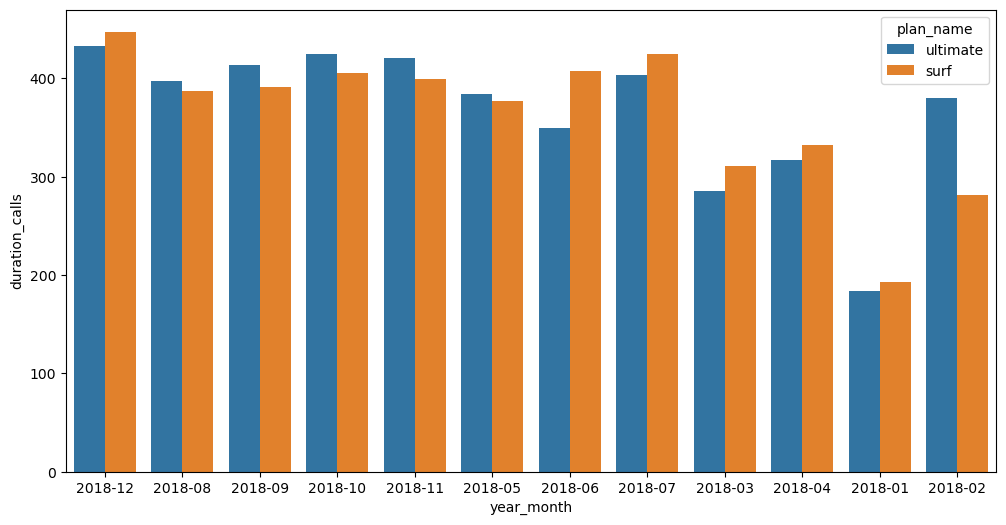

In [150]:
# Creating and Adjusting the Graph
plt.figure(figsize=(12, 6))
sns.barplot(data = merged_data_user, x='year_month', y='duration_calls', hue='plan_name', ci=None)


<Axes: ylabel='Frequency'>

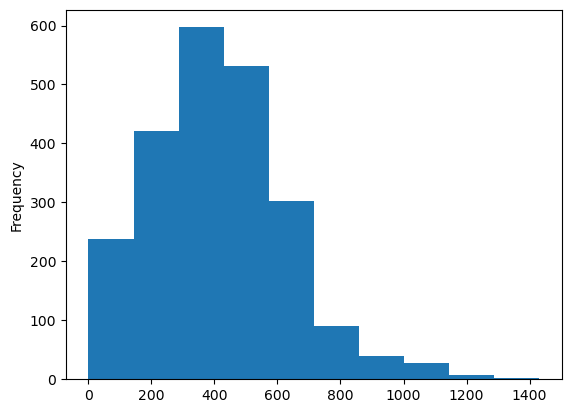

In [151]:
# Comparing the Number of Minutes Used by Users of Each Plan Each Month.
df_sum_duration['duration_calls'].plot.hist()

In [152]:
# Calculating the Average and Variance of Monthly Call Duration
df_sum_duration.groupby('year_month')['duration_calls'].agg(['mean', 'var', 'std'])

,mean,var,std
year_month,,,
2018-01,186.388333,11978.884417,109.448090
2018-02,345.779333,50958.880950,225.740738
2018-03,302.306571,38297.559553,195.697623
2018-04,327.685493,40857.825162,202.133187
2018-05,386.147885,47164.723073,217.174407
2018-06,396.740284,37851.702691,194.555140
2018-07,420.053520,56936.519657,238.613746
2018-08,395.339087,46755.450415,216.230087
2018-09,402.148628,43149.329450,207.724167


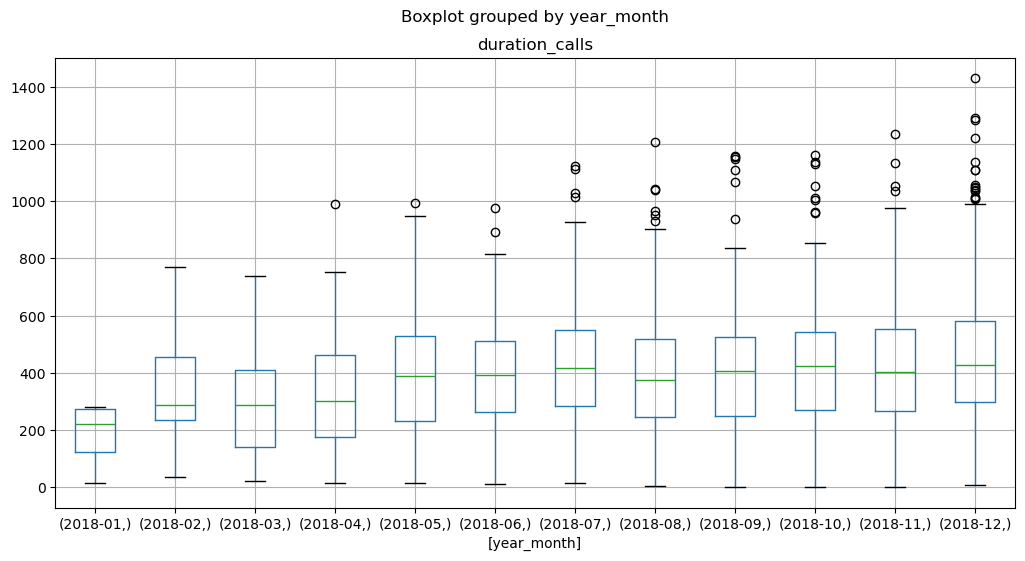

In [153]:
# Creating a Box Plot to Visualize the Distribution of Monthly Call Duration
df_sum_duration[['duration_calls', 'year_month']].boxplot(by=['year_month'], figsize=(12, 6));

Note: The behavior of the users is relatively similar as both extract a lot from their plans according to the contracted service.

### Messages

In [154]:
# Comparing the Number of Messages Sent by Users of Each Plan Each Month
df_messages['month'] = df_messages['year_month'].dt.month

C:\Users\B450M\AppData\Local\Temp\ipykernel_14908\2184507377.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = merged_data_user, x='year_month', y='count_messages', hue='plan_name', ci=None)


<Axes: xlabel='year_month', ylabel='count_messages'>

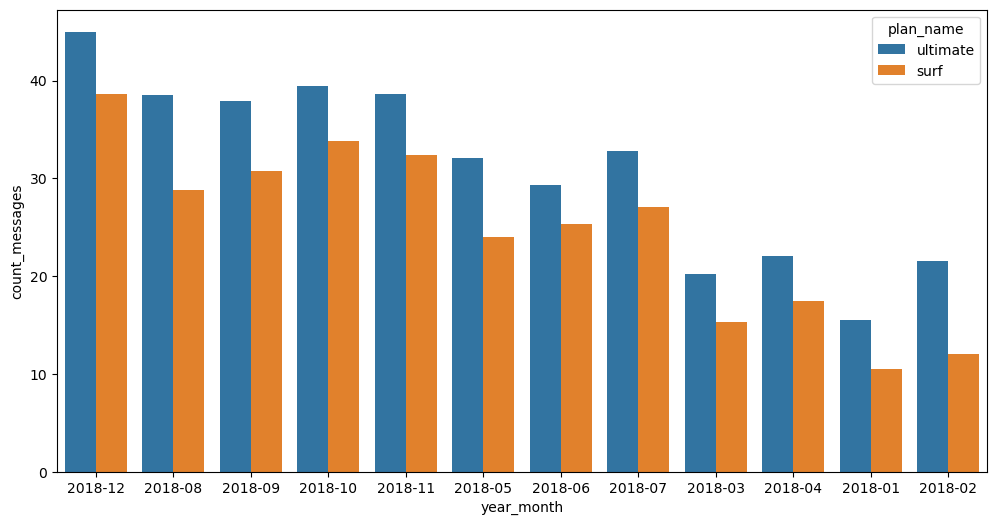

In [155]:
# Creating and Adjusting the Graph
plt.figure(figsize=(12, 6))
sns.barplot(data = merged_data_user, x='year_month', y='count_messages', hue='plan_name', ci=None)

<Axes: ylabel='Frequency'>

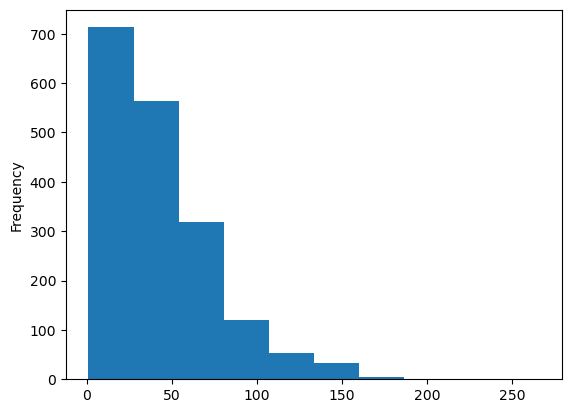

In [156]:
# Comparing the Quantity of Messages Sent by Users by Plan
df_count_messages['count_messages'].plot.hist()

In [157]:
# Obtaining the Average, Variance, and Standard Deviation of the Count of Messages Sent
df_count_messages.groupby('year_month')['count_messages'].agg(['mean', 'var', 'std'])

,mean,var,std
year_month,,,
2018-01,20.750000,206.916667,14.384598
2018-02,23.545455,441.272727,21.006493
2018-03,25.826087,443.604743,21.061926
2018-04,25.634615,522.275641,22.853351
2018-05,36.103896,981.989064,31.336705
2018-06,34.531532,886.069451,29.766919
2018-07,37.739130,890.880355,29.847619
2018-08,40.850829,1037.405402,32.208778
2018-09,41.563063,935.106865,30.579517


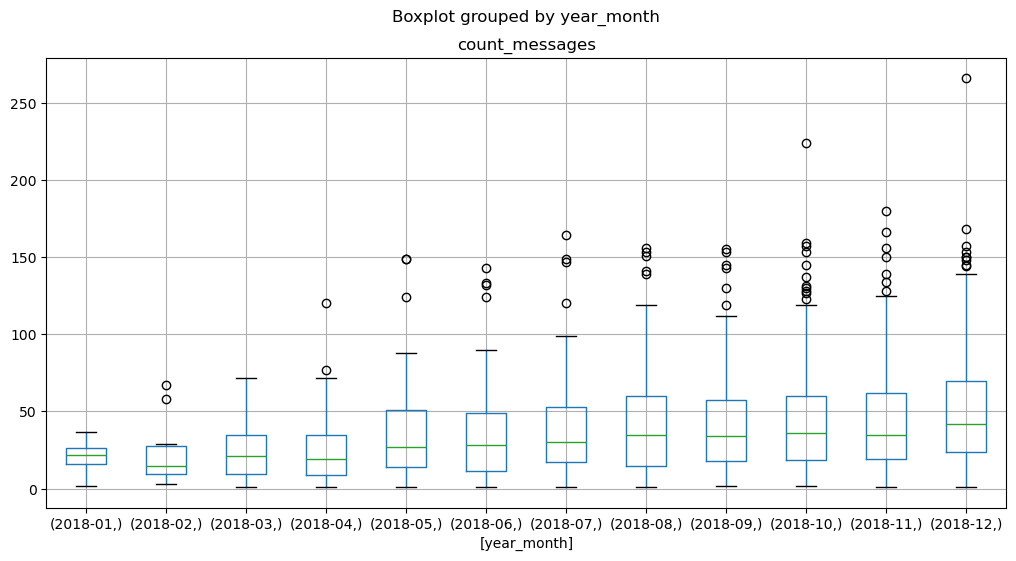

In [158]:
# Creating a Box Plot to Visualize the Distribution of the Count of Messages Sent
df_count_messages[['count_messages', 'year_month']].boxplot(by=['year_month'], figsize=(12, 6));

Note: Users on the Ultimate plan tend to send more messages compared to those on the Surf plan.

### Internet

In [159]:
# Comparing the Amount of Internet Used by Users of Each Plan Each Month
df_internet['month'] = df_internet['year_month'].dt.month

C:\Users\B450M\AppData\Local\Temp\ipykernel_14908\187830614.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = merged_data_user, x='year_month', y='mb_internet', hue='plan_name', ci=None)


<Axes: xlabel='year_month', ylabel='mb_internet'>

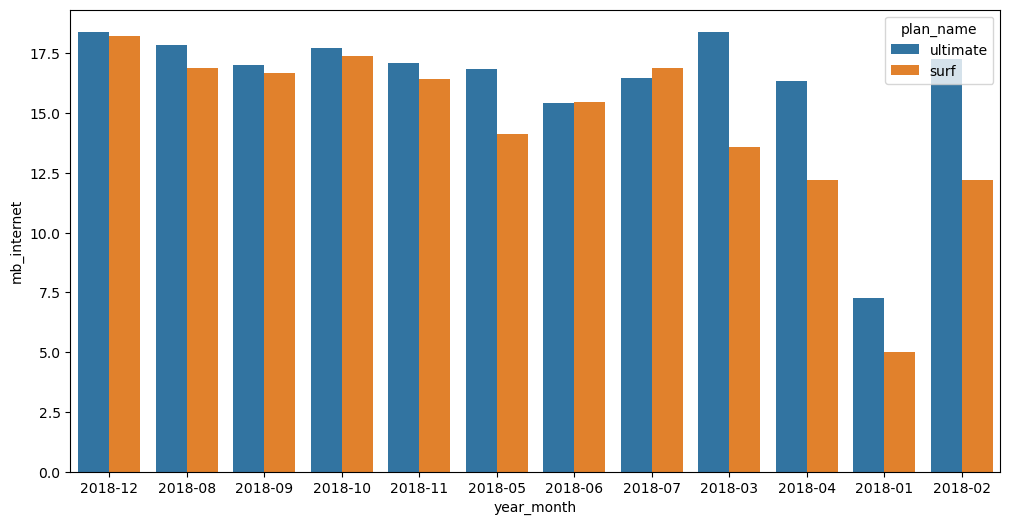

In [160]:
# Creating and Adjusting the Graph
plt.figure(figsize=(12, 6))
sns.barplot(data = merged_data_user, x='year_month', y='mb_internet', hue='plan_name', ci=None)

<Axes: ylabel='Frequency'>

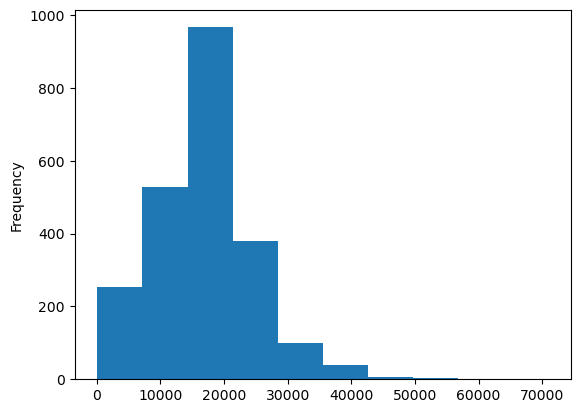

In [161]:
# Comparing the Amount of Internet Traffic Consumed by Users by Plan 
df_internet_mb['mb_internet'].plot.hist()

In [162]:
# Obtaining the Average, Variance, and Standard Deviation of Internet Usage.
df_internet_mb.groupby('year_month')['mb_internet'].agg(['mean', 'var', 'std'])

,mean,var,std
year_month,,,
2018-01,6237.015000,1.459810e+07,3820.745708
2018-02,14344.453125,4.478370e+07,6692.062403
2018-03,15051.524000,9.530571e+07,9762.464219
2018-04,13396.641429,6.866657e+07,8286.529140
2018-05,14811.517333,5.958896e+07,7719.388824
2018-06,15529.088873,5.357382e+07,7319.414218
2018-07,16732.712793,6.438152e+07,8023.809468
2018-08,17329.081783,6.729160e+07,8203.145717
2018-09,16767.550000,4.973496e+07,7052.301680


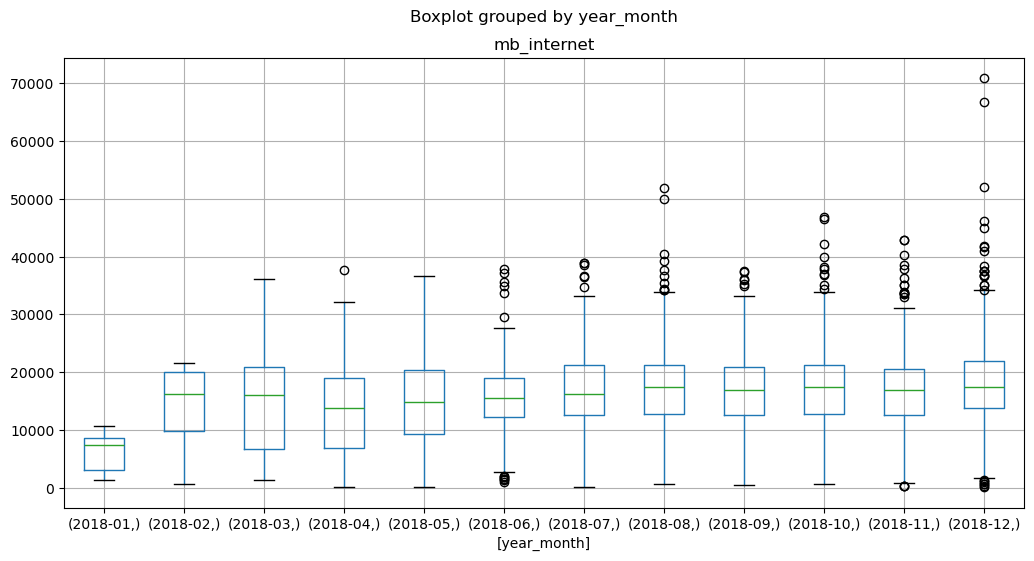

In [163]:
# Creating a Box Plot to Visualize the Distribution of Internet Usage per Month.
df_internet_mb[['mb_internet', 'year_month']].boxplot(by=['year_month'], figsize=(12, 6));

Note: Users on the Ultimate plan are using more GB compared to users on the Surf plan.

## Revenue

Just as the behavior of users was studied, the revenues of the plans will now be described statistically.

C:\Users\B450M\AppData\Local\Temp\ipykernel_14908\3638865879.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = merged_data_user, x='year_month', y='receita', hue='plan_name', ci=None)


<Axes: xlabel='year_month', ylabel='receita'>

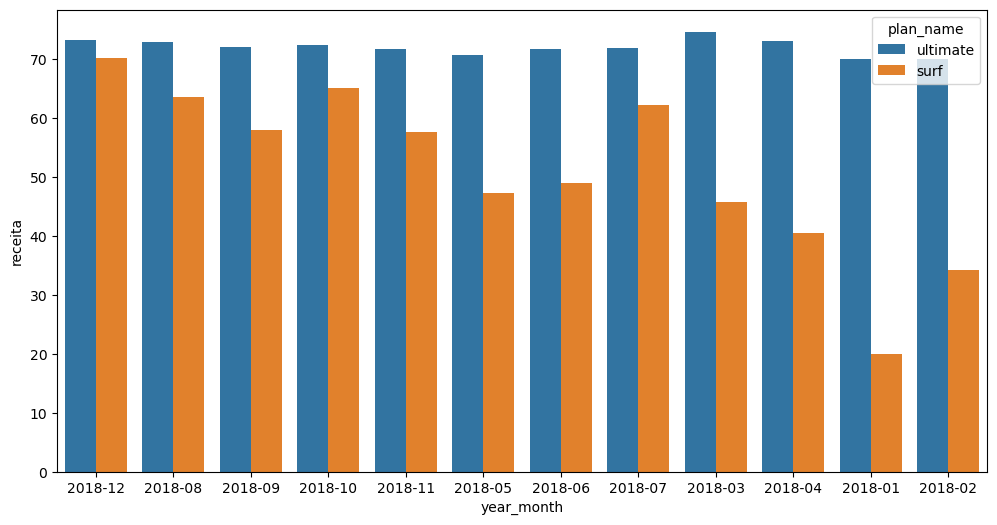

In [164]:
# Creating and Adjusting the Graph
plt.figure(figsize=(12, 6))
sns.barplot(data = merged_data_user, x='year_month', y='receita', hue='plan_name', ci=None)

<Axes: ylabel='Frequency'>

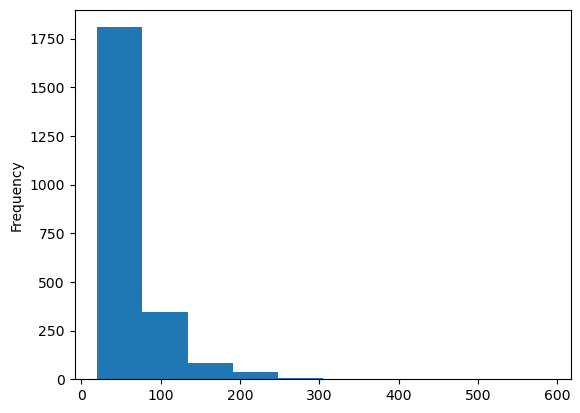

In [165]:
# Comparing Revenue by Users
merged_data_user['receita'].plot.hist()

In [166]:
# Obtaining the Average, Variance, and Standard Deviation of Revenue by Year-Month
merged_data_user.groupby('year_month')['receita'].agg(['mean', 'var', 'std'])

,mean,var,std
year_month,,,
2018-01,53.333333,666.666667,25.819889
2018-02,49.894413,564.683446,23.763069
2018-03,55.690743,1215.985104,34.870978
2018-04,50.080775,1095.989519,33.105732
2018-05,53.661386,1526.046262,39.064642
2018-06,56.342231,1465.991276,38.288266
2018-07,65.393639,2013.007304,44.866550
2018-08,66.402382,2544.354799,50.441598
2018-09,62.275060,1623.499225,40.292670


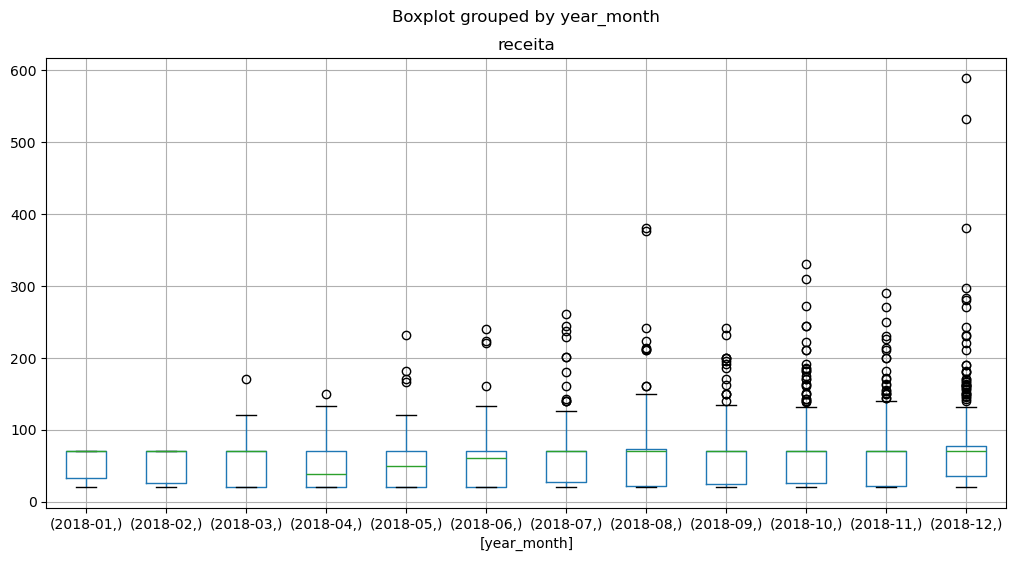

In [167]:
# Creating a Box Plot to Visualize Revenue by Year-Month
merged_data_user[['receita', 'year_month']].boxplot(by=['year_month'], figsize=(12, 6));

Note: The Ultimate plan generates more revenue compared to the Surf plan due to its higher price and the services provided.

## Hypothesis Testing

- Test the hypothesis that the average revenues of users on the Ultimate and Surf calling plans are different.
- Formulate the null and alternative hypotheses, choose the statistical test, and select the alpha level.

In [168]:
df_aux = merged_data_user.groupby(['user_id', 'plan_name'])['receita'].mean().reset_index()

In [169]:
l_ultimate = df_aux.loc[df_aux['plan_name'] == 'ultimate', 'receita'].tolist()

In [170]:
l_surf = df_aux.loc[df_aux['plan_name'] == 'surf', 'receita'].tolist()

In [171]:

alpha = 0.05  # Critical Level of Statistical Significance
# if the p-value is less than alpha, we reject the null hypothesis.

results = st.ttest_ind(l_ultimate, l_surf, equal_var=False) # Performing a Test

print('valor-p: ', results.pvalue) # Extract p-value

if results.pvalue < alpha: # comparing the p-value with the limiar
    print("Rejeitamos a hipótese nula")
else:
    print("Não podemos rejeitar a hipótese nula")

valor-p:  2.4716804827206612e-08
Rejeitamos a hipótese nula


In [172]:
df_city = pd.merge(merged_data_user, df_user, on='user_id')
df_city['NY_NJ'] = df_city['city'].str.contains('NY-NJ')
df_city['NY_NJ']

0       False
1       False
2       False
3       False
4       False
        ...  
2288    False
2289    False
2290    False
2291    False
2292    False
Name: NY_NJ, Length: 2293, dtype: bool

In [173]:
df_city_NY = df_city.groupby(['user_id', 'NY_NJ'])['receita'].mean().reset_index()
l_NY_NJ = df_city_NY.loc[df_city_NY['NY_NJ'] == True, 'receita'].tolist()
l_other_Country = df_city_NY.loc[df_city_NY['NY_NJ'] == False, 'receita'].tolist()

In [174]:
alpha = 0.05  # Critical Level of Statistical Significance
# if the p-value is less than alpha, we reject the null hypothesis.

results = st.ttest_ind(l_NY_NJ, l_other_Country, equal_var=False) # Performing a Test

print('valor-p: ', results.pvalue) # Extract p-value

if results.pvalue < alpha: # comparing the p-value with the limiar
    print("Rejeitamos a hipótese nula")
else:
    print("Não podemos rejeitar a hipótese nula")

valor-p:  0.43103071351514477
Não podemos rejeitar a hipótese nula


## General Conclusion


Note: After following all the established standards for a data analyst, I concluded that there is a statistically significant difference in revenue between the Ultimate and Surf plans. It was found that the Ultimate plan generates more revenue than the Surf plan. Additionally, I confirmed that the average revenue of users in the NY-NJ area does not differ from users in other regions.